<a href="https://colab.research.google.com/github/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install libspatialindex-dev

In [5]:
pip install osmnx

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 11.6MB 6.8MB/s 
     |████████████████████████████████| 972kB 38.6MB/s 
     |████████████████████████████████| 10.9MB 42.9MB/s 
     |████████████████████████████████| 14.9MB 259kB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 14.8MB 276kB/s 
  Created wheel for Rtree: filename=Rtree-0.9.4-cp36-none-any.whl size=21767 sha256=9868d0478bea9d2c29040f727c92fac71c9897761c3d493c10b11122d325a129
  Stored in directory: /root/.cache/pip/wheels/ff/20/c5/0004ef7acb96745ec99be960053902b0b414a2aa2dcad5834e
Successfully built Rtree
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement foli

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

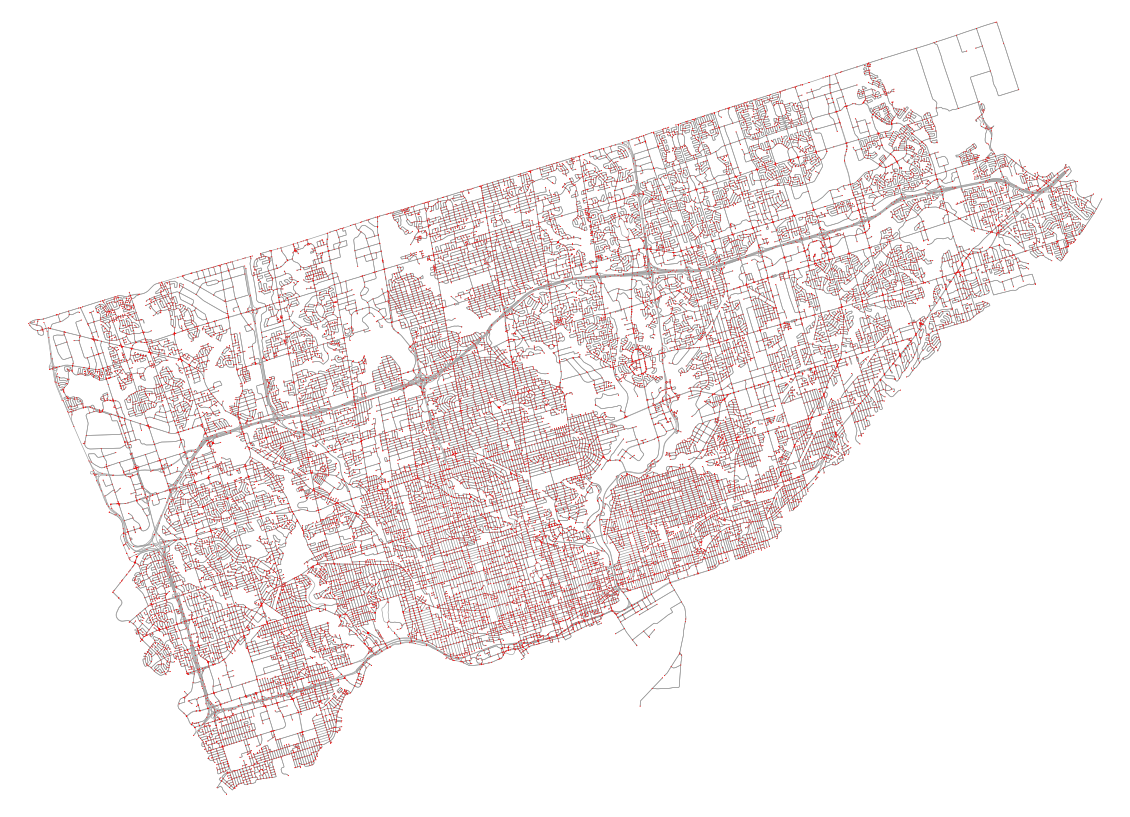

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G, bgcolor='white', node_size=1, node_color="red", edge_linewidth=0.6, edge_alpha=1, dpi=1000, figsize=(20,20))

In [ ]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27440
Number of edges: 73178
Average in degree:   2.6668
Average out degree:   2.6668


In [ ]:
edges =  list(G.edges.data())
edges[160][2]

{'geometry': <shapely.geometry.linestring.LineString at 0x7f7d235ec9e8>,
 'highway': 'secondary',
 'lanes': '4',
 'length': 119.022,
 'maxspeed': '50',
 'name': 'Lawrence Avenue East',
 'oneway': False,
 'osmid': 163720386}

In [ ]:
nodes =  list(G.nodes.data())

## KSI Dataset:

In [ ]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [ ]:
ksi_df.head()

,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,Division,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourhood,ObjectId,geometry
0,3389067,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,50 to 54,Major,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),1,POINT (-79.31880 43.69960)
1,3389068,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),2,POINT (-79.31880 43.69960)
2,3389069,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Driver,55 to 59,Minor,None,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),3,POINT (-79.31880 43.69960)
3,3389070,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,20 to 24,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),4,POINT (-79.31880 43.69960)
4,3389071,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),5,POINT (-79.31880 43.69960)


In [3]:
cols_to_drop = ["geometry", "STREET1", "STREET2", "OFFSET", "ROAD_CLASS", "District", "WardNum", "Division", "Hood_ID", "Neighbourhood"]
ksi_df.drop(cols_to_drop, axis=1, inplace=True)

NameError: ignored

In [ ]:
ksi_df.describe(include='all')

,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,ObjectId
count,1.609300e+04,16093,16093.000000,16093,16093,16093.000000,16093.000000,16093.000000,15963,10643,16064,16071,16093,16066,16093,16089,16083,16093,14484,673,11257,13566,9141,8032,8032,2570,2564,2684,641,666,665,6484,1681,14632,1274,990,982,31,6091,2157,8306,1361,713,450,16093.000000
unique,NaN,5690,NaN,3357,1300,NaN,NaN,NaN,7,9,11,8,9,9,2,10,18,21,5,78,5,27,16,13,10,16,15,10,22,11,10,1,1,1,1,1,1,1,1,1,1,1,1,1,NaN
top,NaN,1311498,NaN,2014-08-17T04:00:00+00:00,1700,NaN,NaN,NaN,Intersection,At Intersection,No Control,Clear,Daylight,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,unknown,None,27,East,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,Pedestrian hit at mid-block,Crossing with right of way,Normal,Motorist turned left across cyclists path.,Driving Properly,Normal,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,NaN
freq,NaN,19,NaN,35,93,NaN,NaN,NaN,10537,7489,7692,13814,9255,12820,13885,6486,7263,2541,6068,12,2846,6594,5407,3704,5167,653,790,1489,109,363,457,6484,1681,14632,1274,990,982,31,6091,2157,8306,1361,713,450,NaN
mean,3.252283e+07,NaN,2011.895793,NaN,NaN,13.310881,43.711126,-79.395698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8047.000000
std,3.594367e+07,NaN,4.010676,NaN,NaN,6.123885,0.056325,0.104088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4645.793276
min,3.363207e+06,NaN,2006.000000,NaN,NaN,0.000000,43.592047,-79.638390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,5.332810e+06,NaN,2008.000000,NaN,NaN,9.000000,43.662644,-79.468326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4024.000000
50%,7.423775e+06,NaN,2012.000000,NaN,NaN,14.000000,43.703345,-79.396373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8047.000000
75%,8.050395e+07,NaN,2015.000000,NaN,NaN,18.000000,43.757045,-79.318065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12070.000000


In [ ]:
ksi_df["ACCLOC"].value_counts()

At Intersection          7489
Non Intersection         1848
Intersection Related      990
At/Near Private Drive     271
Laneway                    17
Private Driveway           13
Overpass or Bridge          8
Underpass or Tunnel         6
Trail                       1
Name: ACCLOC, dtype: int64

In [ ]:
ksi_df["LOCCOORD"].value_counts()

Intersection                           10537
Mid-Block                               5410
Exit Ramp Westbound                        5
Mid-Block (Abnormal)                       4
Exit Ramp Southbound                       3
Entrance Ramp Westbound                    2
Park, Private Property, Public Lane        2
Name: LOCCOORD, dtype: int64

In [ ]:
ksi_df["ACCNUM"].describe()

count       16093
unique       5690
top       1311498
freq           19
Name: ACCNUM, dtype: object

# KSI data on G

In [ ]:
lat_long_map = {}
for index, row in ksi_df1.iterrows():
  key1 = str(row['STREET1']).strip()+" "+str(row['STREET2']).strip()
  key2 = str(row['STREET2']).strip()+" "+str(row['STREET1']).strip()
  if key2 not in lat_long_map:
    if key1 not in lat_long_map:
      lat_long_map[key1] = [row['LONGITUDE'], row['LATITUDE']]
      lat_long_map[key2] = lat_long_map[key1]
  else:
    ksi_df1.at[index, 'LONGITUDE'] = lat_long_map[key2][0]
    ksi_df1.at[index, 'LATITUDE'] = lat_long_map[key2][1]

In [ ]:
X_list = ksi_df1["LONGITUDE"]
Y_list = ksi_df1["LATITUDE"]

In [ ]:
nearest_nodes_array = ox.distance.get_nearest_nodes(G, X_list, Y_list, method='balltree')
nearest_nodes_array[0]

33771082

In [ ]:
#mapping node ids to List of accidents on that node
nodeid_to_accidents = {}
for index, row in ksi_df1.iterrows():
  key = nearest_nodes_array[index]
  if key not in nodeid_to_accidents:
    nodeid_to_accidents[key] = [row]
  else:
    nodeid_to_accidents[key].append(row)


In [ ]:
ksi_nodes = list(set(nearest_nodes_array))
len(ksi_nodes)

3403

In [ ]:
n_colours =[]
for node in G:
  if node in ksi_nodes:
    n_colours.append('red')
  else:
    n_colours.append('grey')

In [ ]:
e_colours =[]
for edge in edges:
  if edge[0] in ksi_nodes and edge[1] in ksi_nodes:
    e_colours.append('green')
  else:
    e_colours.append('grey')

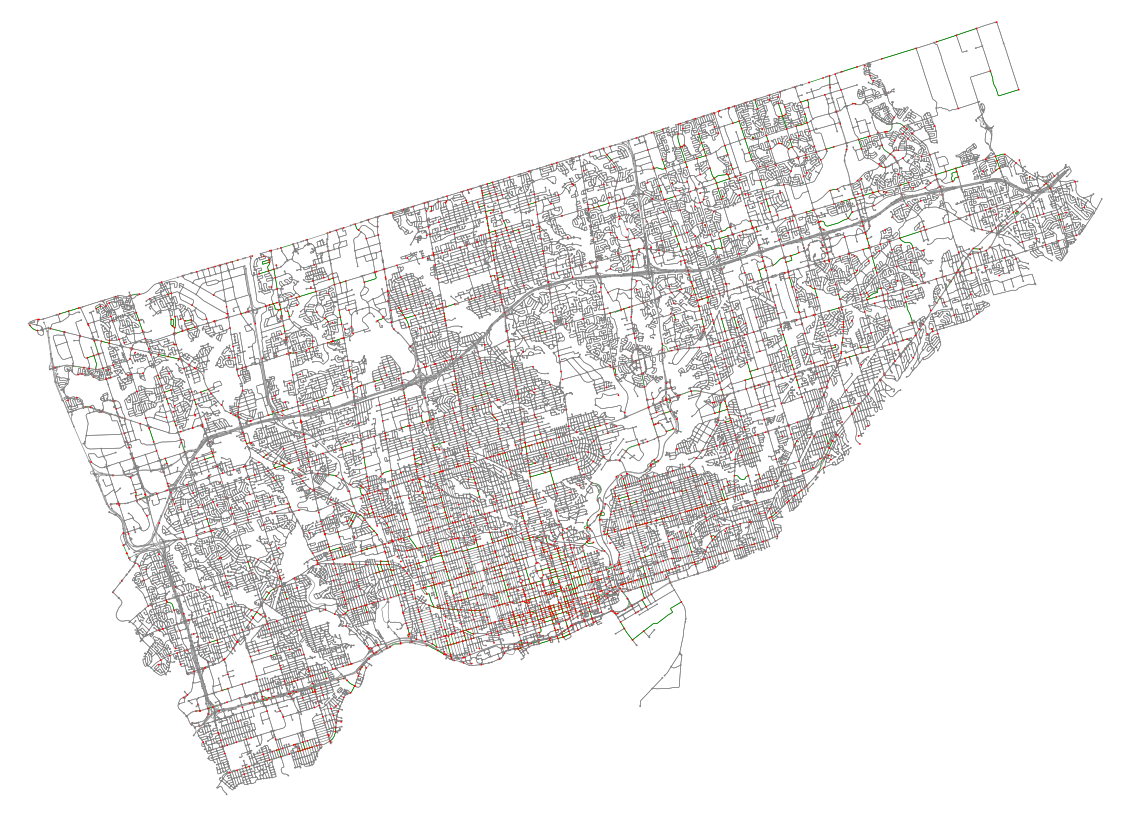

In [ ]:
%matplotlib inline
fig, ax = ox.plot_graph(G, bgcolor='white', node_size=3, node_color=n_colours,edge_color =e_colours, edge_linewidth=0.6, edge_alpha=1, dpi=1000, figsize=(20,20))

In [ ]:
origin_node =  ksi_nodes[0]
dest_node = ksi_nodes[50]
shortest_path = nx.shortest_path(G,origin_node,dest_node)
ox.plot_graph_route(G, shortest_path, bgcolor='white', node_size=3, dpi=1000, figsize=(20,20))

In [ ]:
#(u,v,d) = (node1, node2, data_dict)
for u,v,d in G.edges(data=True):
  d['weight'] = 0
  if u in ksi_nodes and v in ksi_nodes:
      d['weight'] += (len(nodeid_to_accidents[u])/G.degree(u)) + (len(nodeid_to_accidents[v])/G.degree(v))
  else:
    if u in ksi_nodes:
        d['weight'] += (len(nodeid_to_accidents[u])/G.degree(u))
    elif v in ksi_nodes:
        d['weight'] += (len(nodeid_to_accidents[v])/G.degree(v))
    
  

In [ ]:
sorted_weights = sorted(G.edges(data=True), key=lambda x: (-x[2]['weight']))
sorted_weights[2410]

In [ ]:
edges =  list(G.edges(data=True))
edges[12][2]['weight']

In [ ]:
PG = nx.Graph()
for u,v,d in G.edges(data=True):
  w = d['weight']
  if PG.has_edge(u, v):
    PG[u][v]['weight'] += w
  else:
    PG.add_edge(u, v, weight=w)

page_rank = nx.pagerank(PG)

In [ ]:
page_rank[1497793]

In [ ]:
x = 1497793
nodes = G.nodes.data()
print(nodes[x])
print(x in ksi_nodes)
print(x in nodeid_to_accidents)

In [2]:
ksi_df1.loc[(ksi_df1["STREET1"]=="WOODBINE AVE")]
#& (ksi_df1["STREET2"]=="WOODBINE AVE")]

NameError: ignored